In [33]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, RandomizedSearchCV,StratifiedKFold

import keras
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers import Dense,Dropout,Activation
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation, Flatten, Input, concatenate,BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut,  GridSearchCV
# Metrics for model evaluation 
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, precision_score, recall_score, accuracy_score


seed = 7  # fixing random

In [9]:
data=pd.read_csv('data/The_Cancer_data_1500_V2.csv')
data.head()

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1


Exploratory Data Analysis


In [10]:
#a brief statistical summary of the data
data.describe()

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,50.320000,0.490667,27.513321,0.269333,0.508667,4.897929,2.417987,0.144000,0.371333
std,17.640968,0.500080,7.230012,0.443761,0.678895,2.866162,1.419318,0.351207,0.483322
min,20.000000,0.000000,15.000291,0.000000,0.000000,0.002410,0.001215,0.000000,0.000000
25%,35.000000,0.000000,21.483134,0.000000,0.000000,2.434609,1.210598,0.000000,0.000000
50%,51.000000,0.000000,27.598494,0.000000,0.000000,4.834316,2.382971,0.000000,0.000000
75%,66.000000,1.000000,33.850837,1.000000,1.000000,7.409896,3.585624,0.000000,1.000000
max,80.000000,1.000000,39.958688,1.000000,2.000000,9.994607,4.987115,1.000000,1.000000


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1500 non-null   int64  
 1   Gender            1500 non-null   int64  
 2   BMI               1500 non-null   float64
 3   Smoking           1500 non-null   int64  
 4   GeneticRisk       1500 non-null   int64  
 5   PhysicalActivity  1500 non-null   float64
 6   AlcoholIntake     1500 non-null   float64
 7   CancerHistory     1500 non-null   int64  
 8   Diagnosis         1500 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 105.6 KB


Data is clean. No missing data. 

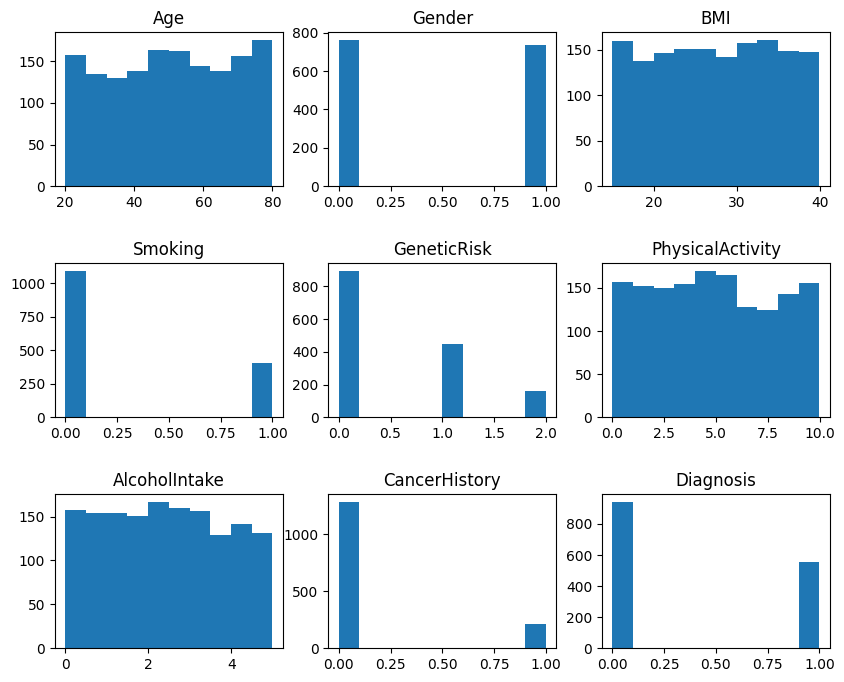

In [19]:
plt.figure(figsize=(10,8))
for i, col in enumerate(data.columns):
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(3,3, i+1)
    plt.hist(data[col])
    plt.title(col)

From the plots above, the data is evenly distributed and cleaned. No further preprocessing is required

Exploring how these parameters affect the ability of a patients to have cancer or not

In [54]:
data2=data.copy()
data2['Diagnosis']=data2['Diagnosis'].map({0: 'No cancer', 1:'cancer present'})
data2.head()

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis,AgeGroup
0,58,1,16.085313,0,1,8.146251,4.148219,1,cancer present,mid-adult
1,71,0,30.828784,0,1,9.361630,3.519683,0,No cancer,adult
2,48,1,38.785084,0,2,5.135179,4.728368,0,cancer present,mid-adult
3,34,0,30.040296,0,0,9.502792,2.044636,0,No cancer,youth
4,62,1,35.479721,0,0,5.356890,3.309849,0,cancer present,adult


In [39]:
fig= px.scatter(data2, x='AlcoholIntake', y='PhysicalActivity',
                color='Diagnosis',color_discrete_sequence=px.colors.qualitative.Alphabet, opacity=0.4)
fig.show()

The scatter plot above shows that physical activity and alcohol intake causes cancer. However, it is not clear to what extent since there is no clear distiction on the plot.
We will investigate this further

In [38]:
fig= px.scatter_3d(data2, x='AlcoholIntake', y='PhysicalActivity', z='GeneticRisk',
                color='Diagnosis',color_discrete_sequence=px.colors.qualitative.Alphabet, opacity=0.4)
fig.show()

From the plot above, it can be noted that people with high genetic risk are prone to cancer even if they dont take alcohol or are physically fit.
People with low genetic risk have a smaller chance of getting cancer

In [55]:
#smoking impact
data2['Smoking']=data2['Smoking'].map({0: 'No', 1:'Yes'})
fig=px.histogram(data2, x='Smoking', color='Diagnosis', barmode='group')
fig.show()

This indicate that the number of people who smoke and had cancer and the ones that smoke and dont have cancer are almost the same. Also, the number of people who dont smoke but has cancer is higher than the number of people who smoke and has cancer.
Hence, we cant conclude if smoking is a direct indicator of cancer

/tmp/ipykernel_7125/3811000600.py:6: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_7125/3811000600.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



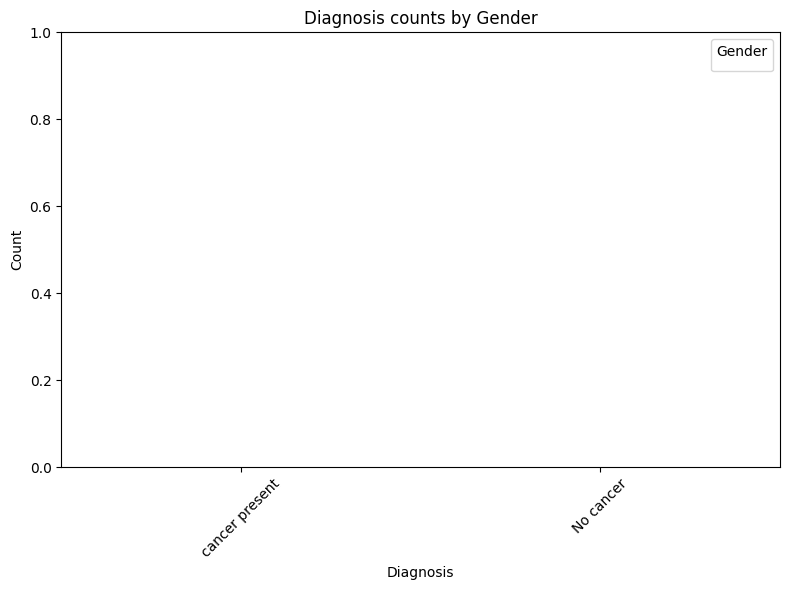

In [68]:
# Histogram: Diagnosis counts grouped by Gender
#smoking impact
data2['Gender']=data2['Gender'].map({0: 'Female', 1: 'Male'})

plt.figure(figsize=(8,6))
sns.countplot(x='Diagnosis', hue='Gender', data=data2, palette='Set2')
plt.title('Diagnosis counts by Gender')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

The plot above implies that about 1/3 of the female population has cancer while the number of male with or without cancer are equal

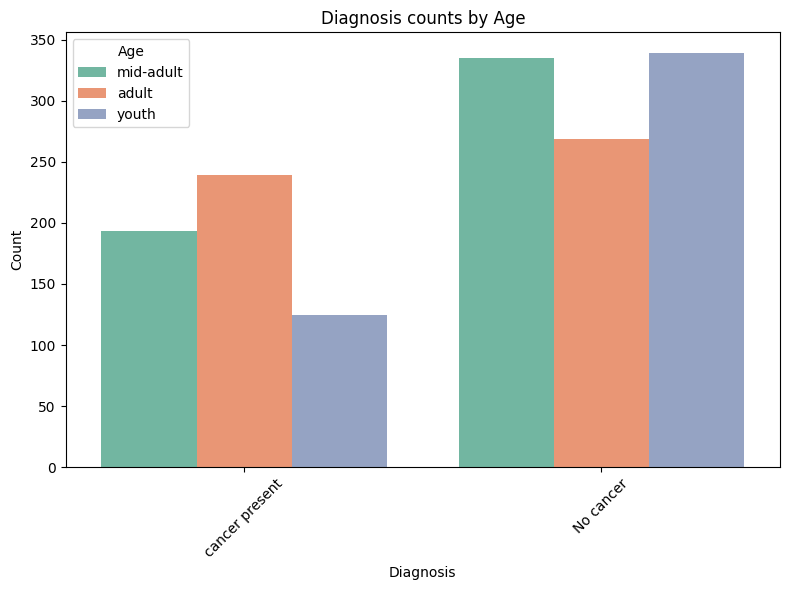

In [70]:
# Histogram: Diagnosis counts grouped by Age
data2["AgeGroup"] = data2["Age"].apply(
    lambda x: "youth" if 20 <= x < 40 
    else ("mid-adult" if 40 <= x < 60 
    else ("adult" if 60 <= x <= 80 
    else None))
)

plt.figure(figsize=(8,6))
sns.countplot(x='Diagnosis', hue='AgeGroup',data=data2, palette='Set2')
plt.title('Diagnosis counts by Age')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Age')
plt.tight_layout()
plt.show()

In [30]:
data.Age.max()

np.int64(80)

In [7]:
data_1.describe()

,Year_of_Birth,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,...,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
count,1568.000000,1552.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,...,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000
mean,1970.073342,62381.186598,0.460459,0.497449,55.408801,2.292730,4.001276,2.665816,5.703444,303.190051,...,26.800383,43.739158,5.326531,0.072704,0.072704,0.080357,0.064413,0.012755,0.008291,0.152423
std,11.920781,32089.169563,0.540361,0.544151,28.788037,1.937544,2.773748,3.043493,3.260553,340.141396,...,40.857657,51.591557,2.468023,0.259733,0.259733,0.271932,0.245566,0.112252,0.090705,0.359546
min,1900.000000,2076.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1960.000000,41612.400000,0.000000,0.000000,31.000000,1.000000,2.000000,0.000000,3.000000,27.000000,...,1.000000,8.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1971.000000,60964.200000,0.000000,0.000000,56.000000,2.000000,3.000000,2.000000,5.000000,167.000000,...,8.000000,25.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1979.000000,81493.200000,1.000000,1.000000,80.000000,3.000000,6.000000,4.000000,8.000000,499.500000,...,33.000000,56.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1997.000000,799999.200000,2.000000,2.000000,106.000000,15.000000,27.000000,28.000000,13.000000,1498.000000,...,263.000000,362.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
data_1.corr()

,Year_of_Birth,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,...,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
Year_of_Birth,1.000000,-0.169006,0.242429,-0.353991,-0.014155,-0.061246,-0.165289,-0.140005,-0.159045,-0.191037,...,-0.044336,-0.071109,0.135795,0.067942,-0.065205,-0.012450,0.002963,0.007885,0.002978,0.012279
Disposable_Income,-0.169006,1.000000,-0.420914,0.021720,-0.006822,-0.066990,0.380671,0.553196,0.490041,0.541937,...,0.418429,0.320388,-0.530072,-0.016061,0.169711,0.333425,0.259968,0.082295,-0.029043,0.130254
No_of_Kids_in_home,0.242429,-0.420914,1.000000,-0.048091,0.008404,0.211293,-0.384441,-0.508997,-0.521173,-0.519091,...,-0.384115,-0.372180,0.450402,0.020496,-0.165929,-0.225912,-0.170760,-0.086368,0.026223,-0.108558
No_of_Teen_in_home,-0.353991,0.021720,-0.048091,1.000000,0.014712,0.373262,0.155173,-0.088757,0.073129,0.005626,...,-0.140542,-0.013651,0.125594,-0.057385,0.055496,-0.209937,-0.158758,-0.009915,0.006894,-0.156209
Recency,-0.014155,-0.006822,0.008404,0.014712,1.000000,-0.006311,-0.026068,0.029136,-0.008498,0.019051,...,0.034841,-0.000920,-0.022179,-0.018657,0.004643,0.005828,-0.040377,-0.028077,0.020208,-0.201654
Discounted_Purchases,-0.061246,-0.066990,0.211293,0.373262,-0.006311,1.000000,0.204052,0.026556,0.058702,-0.001913,...,-0.102849,0.046953,0.333250,-0.037245,0.019819,-0.191230,-0.121472,-0.028915,-0.013818,0.000951
WebPurchases,-0.165289,0.380671,-0.384441,0.155173,-0.026068,0.204052,1.000000,0.361998,0.518604,0.530179,...,0.394216,0.419859,-0.088528,0.029988,0.128313,0.142003,0.145100,0.024543,-0.015261,0.165538
CatalogPurchases,-0.140005,0.553196,-0.508997,-0.088757,0.029136,0.026556,0.361998,1.000000,0.497271,0.630364,...,0.476969,0.429251,-0.525378,0.098568,0.126016,0.340899,0.297788,0.094675,-0.024632,0.221534
StorePurchases,-0.159045,0.490041,-0.521173,0.073129,-0.008498,0.058702,0.518604,0.497271,1.000000,0.647018,...,0.440027,0.407657,-0.426029,-0.058922,0.172418,0.233461,0.202406,0.088803,-0.013259,0.061446
Amount_on_Wines,-0.191037,0.541937,-0.519091,0.005626,0.019051,-0.001913,0.530179,0.630364,0.647018,1.000000,...,0.383789,0.405581,-0.338141,0.073176,0.374574,0.509900,0.371342,0.207473,-0.031781,0.259173


In [9]:
data_1.isnull()

,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,WebPurchases,...,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1564,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1565,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1566,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
#Encoding categorical data

In [11]:
X = pd.get_dummies(data_1['Education_Level'])
X.head()

,2n Cycle,Basic,Graduation,Master,PhD
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,0,0,1,0,0


In [12]:
T=pd.get_dummies(data_1['Marital_Status'])
T.head()

,Absurd,Alone,Divorced,Married,Single,Together,Widow,YOLO
0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0


In [13]:
data_1=pd.concat([data_1, X, T], axis=1)

In [14]:
data_1.corr()

,Year_of_Birth,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,...,Master,PhD,Absurd,Alone,Divorced,Married,Single,Together,Widow,YOLO
Year_of_Birth,1.000000,-0.169006,0.242429,-0.353991,-0.014155,-0.061246,-0.165289,-0.140005,-0.159045,-0.191037,...,-0.084174,-0.137000,0.050720,0.014426,-0.079010,0.043942,0.139038,-0.063255,-0.163767,0.011775
Disposable_Income,-0.169006,1.000000,-0.420914,0.021720,-0.006822,-0.066990,0.380671,0.553196,0.490041,0.541937,...,0.019667,0.065488,0.025893,-0.013492,0.018686,-0.028694,-0.039233,0.042255,0.033506,-0.004773
No_of_Kids_in_home,0.242429,-0.420914,1.000000,-0.048091,0.008404,0.211293,-0.384441,-0.508997,-0.521173,-0.519091,...,0.008852,-0.033108,-0.021533,0.043730,-0.008655,0.035830,0.007275,-0.014325,-0.067349,-0.030462
No_of_Teen_in_home,-0.353991,0.021720,-0.048091,1.000000,0.014712,0.373262,0.155173,-0.088757,0.073129,0.005626,...,0.034259,0.096352,-0.023101,0.013620,0.073427,-0.004637,-0.082522,0.012131,0.040887,0.033016
Recency,-0.014155,-0.006822,0.008404,0.014712,1.000000,-0.006311,-0.026068,0.029136,-0.008498,0.019051,...,-0.018314,0.010540,0.008419,-0.027499,-0.006974,-0.022531,0.016137,0.017704,0.010035,-0.056388
Discounted_Purchases,-0.061246,-0.066990,0.211293,0.373262,-0.006311,1.000000,0.204052,0.026556,0.058702,-0.001913,...,0.032581,0.019553,-0.016860,0.031057,0.016859,0.048536,-0.055236,-0.018541,-0.004941,0.049950
WebPurchases,-0.165289,0.380671,-0.384441,0.155173,-0.026068,0.204052,1.000000,0.361998,0.518604,0.530179,...,-0.012846,0.052222,-0.000012,0.015770,0.020418,-0.013560,-0.028480,0.008108,0.036569,0.038648
CatalogPurchases,-0.140005,0.553196,-0.508997,-0.088757,0.029136,0.026556,0.361998,1.000000,0.497271,0.630364,...,-0.010254,0.067460,0.060895,-0.028768,-0.002684,-0.019095,-0.021134,0.022762,0.052146,-0.019566
StorePurchases,-0.159045,0.490041,-0.521173,0.073129,-0.008498,0.058702,0.518604,0.497271,1.000000,0.647018,...,0.026335,0.037428,0.010049,-0.022881,0.005932,0.009771,-0.030481,-0.000761,0.038784,0.003251
Amount_on_Wines,-0.191037,0.541937,-0.519091,0.005626,0.019051,-0.001913,0.530179,0.630364,0.647018,1.000000,...,0.055686,0.145413,0.012838,-0.014617,0.004174,-0.012726,-0.034489,0.021457,0.055781,0.002502


In [15]:
X_test = pd.get_dummies(data_test['Education_Level'])
X_test.head()

,2n Cycle,Basic,Graduation,Master,PhD
0,0,0,1,0,0
1,0,0,1,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,1,0,0


In [16]:
Z=pd.get_dummies(data_test['Marital_Status'])
Z.head()

,Absurd,Divorced,Married,Single,Together,Widow
0,0,0,0,1,0,0
1,0,0,0,0,0,1
2,0,0,1,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [17]:
data_test=pd.concat([data_test, X_test, Z], axis=1)


In [18]:
data_2=data_1.drop(['Education_Level','Marital_Status','Date_Customer','Disposable_Income', 'YOLO', 'Alone'], axis=1)


In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector as Feature_selection


In [35]:
Feature_selection = Feature_selection(pipe, 
           k_features=1, 
           forward=False, 
           scoring='neg_mean_squared_error',
           )

X = data_2.drop(columns='Response')

Feature_selection.fit(X,y)
Feature_selection.subsets_

{32: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31),
  'cv_scores': array([-0.12101911, -0.11464968, -0.13375796, -0.11821086, -0.11821086]),
  'avg_score': -0.12116969536639466,
  'feature_names': ('Year_of_Birth',
   'No_of_Kids_in_home',
   'No_of_Teen_in_home',
   'Recency',
   'Discounted_Purchases',
   'WebPurchases',
   'CatalogPurchases',
   'StorePurchases',
   'Amount_on_Wines',
   'Amount_on_Fruits',
   'Amount_on_MeatProducts',
   'Amount_on_FishProducts',
   'Amount_on_SweetProducts',
   'Amount_on_GoldProds',
   'WebVisitsMonth',
   'Cmp3Accepted',
   'Cmp4Accepted',
   'Cmp5Accepted',
   'Cmp1Accepted',
   'Cmp2Accepted',
   'Any_Complain',
   '2n Cycle',
   'Basic',
   'Graduation',
   'Master',
   'PhD',
   'Absurd',
   'Divorced',
   'Married',
   'Single',
   'Together',
   'Widow')},
 31:

In [23]:
X=data_2.drop('Response', axis=1)
y=data_2['Response']



Transformation

In [24]:
from sklearn.preprocessing import StandardScaler
Scaler=StandardScaler()
#transforming my data
Scaler_transform=Scaler.fit_transform(X)

In [25]:
scale_result=np.vstack((X.mean(axis=0), X.var(axis=0),Scaler_transform.mean(axis=0), Scaler_transform.var(axis=0) )).T
#creating a dict
this_dict={'feature_names': ['Year_of_Birth','No_of_Kids_in_home','No_of_Teen_in_home','Recency','Discounted_Purchases','WebPurchases',
                           'CatalogPurchases','StorePurchases','Amount_on_Wines','Amount_on_Fruits','Amount_on_MeatProducts','Amount_on_FishProducts',
                           'Amount_on_SweetProducts','Amount_on_GoldProds','WebVisitsMonth','Any_Complain','2n Cycle','Basic','Graduation','Master','PhD',
                           'Absurd','Divorced','Married','Single','Together','Widow','Cmp3Accepted','Cmp1Accepted',
                    'Cmp2Accepted','Cmp4Accepted','Cmp5Accepted']}
feature_names=this_dict['feature_names']
columns=['unscaled_mean', 'unscaled_variance', 'scaled_mean', 'scaled_variance']
df=pd.DataFrame(scale_result, index=feature_names, columns=columns)
df


,unscaled_mean,unscaled_variance,scaled_mean,scaled_variance
Year_of_Birth,1970.073342,142.105020,-3.823472e-16,1.0
No_of_Kids_in_home,0.460459,0.291990,-1.982541e-17,1.0
No_of_Teen_in_home,0.497449,0.296101,-6.344132e-17,1.0
Recency,55.408801,828.751090,1.812609e-17,1.0
Discounted_Purchases,2.292730,3.754076,-1.586033e-17,1.0
WebPurchases,4.001276,7.693681,9.516197e-17,1.0
CatalogPurchases,2.665816,9.262851,-9.063045e-18,1.0
StorePurchases,5.703444,10.631207,2.605625e-17,1.0
Amount_on_Wines,303.190051,115696.169346,-7.930164e-17,1.0
Amount_on_Fruits,29.091199,1565.439667,-4.531523e-18,1.0


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score, confusion_matrix, classification_report
#constructing my pipeline
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=99)

Lrt=GradientBoostingClassifier()
Polynomial_f=PolynomialFeatures()
Scaler=StandardScaler()


pipe=Pipeline([('scaler', Scaler),
               ('poly', Polynomial_f),
               ('classifier', Lrt)
              ])

In [27]:
#using pipeline to fit my data
pipe_fit=pipe.fit(X_train,y_train)
pipe_predict=pipe_fit.predict(X_val)


print(pipe_predict)
print(precision_score(y_val, pipe_predict))
print(recall_score(y_val, pipe_predict))
print(accuracy_score(y_val,pipe_predict))
print(f1_score(y_val, pipe_predict))




[0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
0.7142857142857143
0.5434782608695652
0.9012738853503185
0.617283950617284


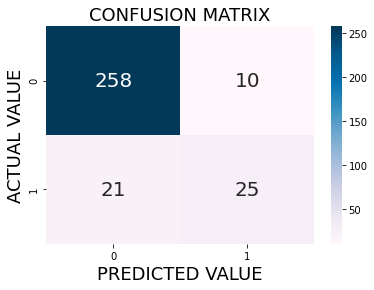

In [28]:
confusion_Matrix=confusion_matrix(y_val, pipe_predict)
sns.heatmap(confusion_Matrix,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
plt.xlabel('PREDICTED VALUE', fontsize=18)
plt.ylabel('ACTUAL VALUE', fontsize=18)
plt.title('CONFUSION MATRIX', fontsize=18)
    
plt.show()

In [29]:
data_test_1=data_test.drop(['Education_Level','Marital_Status','Date_Customer','Disposable_Income', ], axis=1)
data_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Year_of_Birth            672 non-null    int64
 1   No_of_Kids_in_home       672 non-null    int64
 2   No_of_Teen_in_home       672 non-null    int64
 3   Recency                  672 non-null    int64
 4   Discounted_Purchases     672 non-null    int64
 5   WebPurchases             672 non-null    int64
 6   CatalogPurchases         672 non-null    int64
 7   StorePurchases           672 non-null    int64
 8   Amount_on_Wines          672 non-null    int64
 9   Amount_on_Fruits         672 non-null    int64
 10  Amount_on_MeatProducts   672 non-null    int64
 11  Amount_on_FishProducts   672 non-null    int64
 12  Amount_on_SweetProducts  672 non-null    int64
 13  Amount_on_GoldProds      672 non-null    int64
 14  WebVisitsMonth           672 non-null    int64
 15  Cmp3Ac

In [30]:
pipe_fit_1=pipe.fit(X,y)
Response_predict=pipe_fit_1.predict(data_test_1)

In [31]:
print(Response_predict)

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 

In [32]:
submission = pd.read_csv('SampleSubmission.csv')
submission.head()

,ID,Response
0,ID_ZPMABNVX,NaN
1,ID_WFE91NAA,NaN
2,ID_JV11RBRK,NaN
3,ID_6B7SVKY9,NaN
4,ID_GOVUZ545,NaN


In [33]:
submission['Response'] = Response_predict
submission.head()

,ID,Response
0,ID_ZPMABNVX,0
1,ID_WFE91NAA,0
2,ID_JV11RBRK,0
3,ID_6B7SVKY9,0
4,ID_GOVUZ545,0


In [34]:
submission.to_csv('sub_1.csv', index=False)